# CNN for ECG images classification for triage

### Imports and CUDA

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
import torch.utils.data as data

import torch.nn.functional as F
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### ECG Image Dataset


Have ECG_image_data folder in the same directory to get path

In [3]:
# Train and Test data folders
train_folder = "ECG_Image_data/train/"
test_folder = "ECG_Image_data/test/"

Considered reducing number of images used for training and testing through data.subset in order to avoid gpu memory exceeding and long runtime, however managed to fix those issues.

In [4]:
# Train and Test ImageFolders for dataset
train_dataset = ImageFolder(train_folder,transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
]))

# subset_indices = []
# for class_idx in range(len(train_dataset.classes)):
#     class_indices = [idx for idx in range(len(train_dataset)) if train_dataset[idx][1] == class_idx]
#     subset_indices.extend(class_indices[:600])
# train_dataset = data.Subset(train_dataset, subset_indices)


test_dataset = ImageFolder(test_folder,transforms.Compose([
    transforms.Resize((150,150)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
]))

# subset_indices = []
# for class_idx in range(len(test_dataset.classes)):
#     class_indices = [idx for idx in range(len(test_dataset)) if test_dataset[idx][1] == class_idx]
#     subset_indices.extend(class_indices[:60])
# test_dataset = data.Subset(test_dataset, subset_indices)

In [5]:
img, label = train_dataset[0]
print(img.shape,label)

torch.Size([1, 150, 150]) 0


In [6]:
print("The classes are : \n",train_dataset.classes)

The classes are : 
 ['F', 'M', 'N', 'Q', 'S', 'V']


displaying first image in train_dataset

Label : F


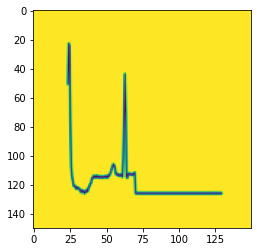

In [7]:
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
img, label = train_dataset[0]
display_img(img, label)

In [8]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

# Preparing Data, splitting into batches

batch_size = 8
val_size = 9000
train_size = len(train_dataset) - val_size 

train_data,val_data = random_split(train_dataset,[train_size,val_size])
print(f"Train size : {len(train_data)}")
print(f"Validation Size : {len(val_data)}")


#load the train and validation into batches.
train_dataloader = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4)
val_dataloader = DataLoader(val_data, batch_size, shuffle = True, num_workers = 4)

Train size : 90199
Validation Size : 9000


Sample of images in train dataloader batch

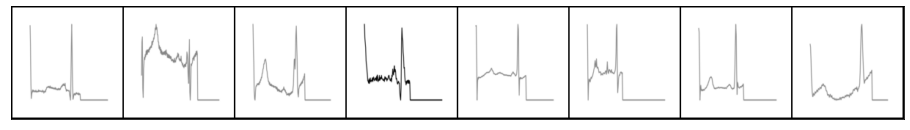

In [48]:
# Images of a batch in training data

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        # print(images)
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dataloader)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ClassifierBase(nn.Module):
    
    # Forward
    def training_step(self, batch):
        images, labels = batch 
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        # Pass through model and get prediction outputs
        out = self(images)           
        # Calculate loss       
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        # Pass through model and get prediction outputs
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        # Calculate accuracy
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [11]:
class ECG_Classifier(ClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(512,512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(512,512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            
            nn.Flatten(),
            nn.Linear(8192,4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(1024,6)

        )
    
    def forward(self, xb):
        return self.network(xb)

In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    num_epochs = epochs
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()

        pbar = tqdm(total=len(train_loader))

        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            pbar.update(1)
            pbar.set_description(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

        pbar.close()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [13]:
model = ECG_Classifier().to(device)
num_epochs = 10
optimizer = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dataloader, val_dataloader, optimizer)

  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.1535, val_loss: 0.0163, val_acc: 0.9947


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0355, val_loss: 0.0245, val_acc: 0.9938


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0272, val_loss: 0.0126, val_acc: 0.9961


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0214, val_loss: 0.0256, val_acc: 0.9954


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0200, val_loss: 9.1387, val_acc: 0.8528


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0186, val_loss: 0.0143, val_acc: 0.9964


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0183, val_loss: 0.0192, val_acc: 0.9941


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0151, val_loss: 0.0147, val_acc: 0.9971


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0172, val_loss: 0.0125, val_acc: 0.9967


Epoch 10/10, Loss: 0.0000: 100%|██████████| 11275/11275 [12:49<00:00, 14.66it/s]


Epoch [9], train_loss: 0.0149, val_loss: 0.0088, val_acc: 0.9970


Save Model

In [14]:
torch.save(model.state_dict(), "ECG-model.pth")

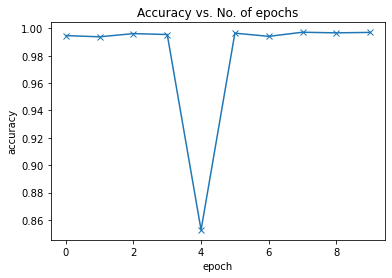

In [91]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    return
    

plot_accuracies(history)


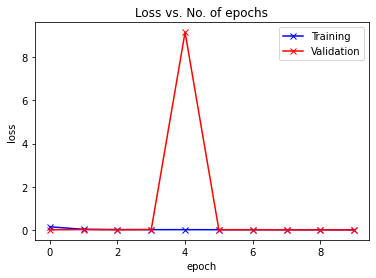

In [92]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    return

plot_losses(history)

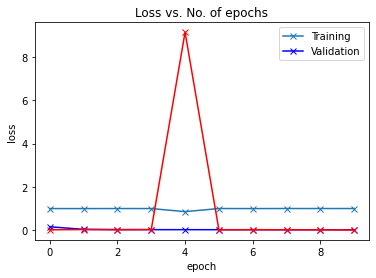

In [17]:
plot_accuracies(history)

plot_losses(history)

In [95]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

In [18]:
test_dataloader = DataLoader(test_dataset, batch_size, shuffle = True, num_workers = 4)

 Test Accuracy: 99.75805476027259%


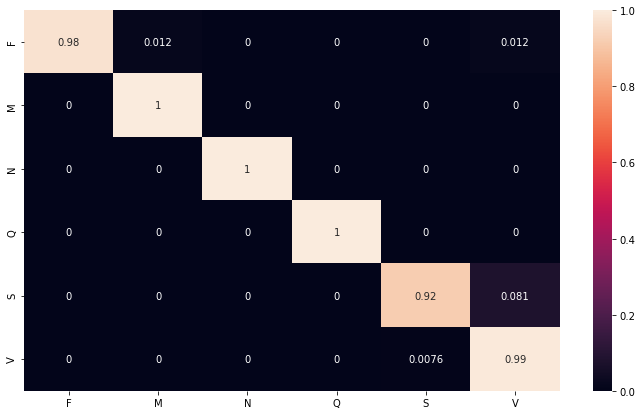

In [94]:
# for epoch in range(10):
correct = 0
total = 0

y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_dataloader:
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.data.cpu().numpy())
        lol = labels
        y_true.extend(lol.data.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(' Test Accuracy: {}%'.format(accuracy))

classes = ('F', 'M', 'N', 'Q', 'S','V') 
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [105]:
print(cf_matrix)

[[  157     2     0     0     0     2]
 [    0  2101     0     0     0     0]
 [    0     0 18926     0     0     0]
 [    0     0     0  1608     0     0]
 [    0     0     0     0   511    45]
 [    0     0     0     0    11  1436]]


In [104]:
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

           F       1.00      0.98      0.99       161
           M       1.00      1.00      1.00      2101
           N       1.00      1.00      1.00     18926
           Q       1.00      1.00      1.00      1608
           S       0.98      0.92      0.95       556
           V       0.97      0.99      0.98      1447

    accuracy                           1.00     24799
   macro avg       0.99      0.98      0.99     24799
weighted avg       1.00      1.00      1.00     24799



In [ ]:
y_pred = []
y_true = []

# iterate over test data
for images, labels in test_dataloader:
        output = model(images) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

Load Model

In [20]:
newmodel = ECG_Classifier().to(device)
newmodel.load_state_dict(torch.load('ECG-model.pth'))
newmodel.eval()
# with open("iris-model.pickle", "rb") as fp:
#     model.load_state_dict(pickle.load(fp))

ECG_Classifier(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

In [85]:
correct = 0
total = 0
failed = []
failed_label=[]
predicted_label=[]
with torch.no_grad():
    for images, labels in test_dataloader:
        if torch.cuda.is_available():
            images_dev = images.to(device)
            labels = labels.to(device)
        outputs = newmodel(images_dev)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if predicted.sum().item() != labels.sum().item():
            for i in range(8):
                if predicted[i].item() != labels[i].item():
                    failed.append(images[i])
                    failed_label.append(labels[i])
                    predicted_label.append(predicted[i])

accuracy = 100 * correct / total
print(' Test Accuracy: {}%'.format(accuracy))

 Test Accuracy: 99.75805476027259%


In [86]:
print(correct)
print(total)
print(len(failed))

24739
24799
60


In [87]:
def label_to_class(val):
    value = ""
    if val == 0: value = "F"
    elif val == 1: value = "M"
    elif val == 2: value = "N"
    elif val == 3: value = "Q"
    elif val == 4: value = "S"
    else: value = "V"
    return value

S
S
S
S
F
ECG Image 1 Actual class :  S , but predicted as :  V
ECG Image 2 Actual class :  S , but predicted as :  V
ECG Image 3 Actual class :  S , but predicted as :  V
ECG Image 4 Actual class :  S , but predicted as :  V
ECG Image 5 Actual class :  F , but predicted as :  V


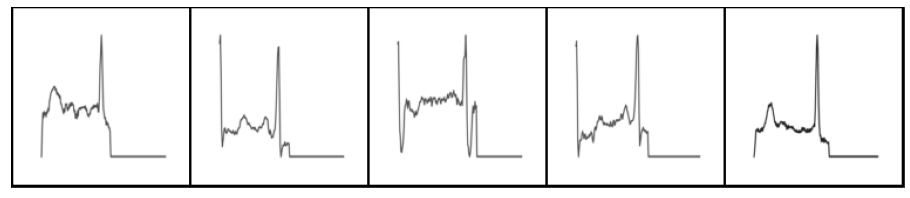

In [88]:
first_five = failed[0:5]
fig,ax = plt.subplots(figsize = (16,12))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(first_five,nrow=16).permute(1,2,0))

# print(failed_label[0:5])
for label in failed_label[0:5]:
    val = label.item()
    if val == 0: print("F")
    elif val == 1: print("M")
    elif val == 2: print("N")
    elif val == 3: print("Q")
    elif val == 4: print("S")
    else: print("V")

for i in range(5):
    label = failed_label[i].item()
    pred = predicted_label[i].item()
    print("ECG Image", i+1, "Actual class : ", label_to_class(label), ", but predicted as : ", label_to_class(pred) )


['F', 'M', 'N', 'Q', 'S', 'V']

In [89]:
f_counter = 0
m_counter = 0
n_counter = 0
q_counter = 0
s_counter = 0
v_counter = 0
for label in failed_label:
    val = label.item()
    if val == 0: f_counter += 1
    elif val == 1: m_counter += 1
    elif val == 2: n_counter += 1
    elif val == 3: q_counter += 1
    elif val == 4: s_counter += 1
    else: v_counter += 1

print("The incorrect classification counts are : \n", "F :", f_counter, ", M :", m_counter, ", N :", n_counter, ", Q :", q_counter, ", S :", s_counter, ", V :", v_counter)

The incorrect classification counts are : 
 F : 4 , M : 0 , N : 0 , Q : 0 , S : 45 , V : 11


In [90]:
incorrect_abnormal_count= f_counter + m_counter + q_counter +s_counter+v_counter
incorrect_normal_count = n_counter

print("Abnormal classified incorrectly :", incorrect_abnormal_count)
print("Normal classified incorrectly :", incorrect_normal_count)

Abnormal classified incorrectly : 60
Normal classified incorrectly : 0
